In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import time
import faiss
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
wendy_data_directory = '/users/Wendy/Capstone/saudi_arabia_112019_tweets_csv_hashed_1.csv'
gefei_data_directory = '/Users/Sylvia/Desktop/1006/saudi_arabia_112019_tweets_csv_hashed/saudi_arabia_112019_tweets_csv_hashed_1.csv'
tweets = pd.read_csv(wendy_data_directory)
tweets = tweets.drop_duplicates()

/var/folders/5t/drh_ys0122sf_3q7npyxb3mh0000gn/T/ipykernel_13515/458815862.py:3: DtypeWarning: Columns (15,19) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets = pd.read_csv(wendy_data_directory)


In [3]:
import re

def tokenize_mentions_and_links(text):
    # Remove mentions
    text = re.sub(r'@\w+', '@USER', text)

    # Remove URLs
    text = re.sub(r'http\S+', '<url>', text)

    return text

tweets['cleaned_text'] = tweets['tweet_text'].apply(tokenize_mentions_and_links)

## faiss

### 500 english tweets

In [4]:
sample_tweets_english = tweets[(tweets['tweet_language'] == 'en') & (tweets['is_retweet']==False)]['cleaned_text'][:500]
sample_tweets_english=sample_tweets_english.tolist()
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
start_time = time.time()
embeddings_english = model.encode(list(sample_tweets_english), convert_to_tensor=True)
end_time = time.time()
print("MiniLM Embedding Time for 500 Tweets: {}".format(end_time-start_time))



MiniLM Embedding Time for 500 Tweets: 7.750313997268677


### 5000 tweets

In [9]:
model_MiniLM = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
start_time = time.time()
sample_tweets_5000 = tweets[:5000]['cleaned_text']
embeddings_5000 = model.encode(list(sample_tweets_5000), convert_to_tensor=True)
end_time = time.time()
print("MiniLM Embedding Time for 5000 Tweets: {}".format(end_time-start_time))

MiniLM Embedding Time for 5000 Tweets: 94.43160080909729


## How to use faiss to do clustering?

### Clustering with flat indexing

In [5]:
embeddings_arr = np.array(embeddings_english)

In [18]:
start_time = time.time()
num_tweets, embedding_dim = embeddings_arr.shape


# Normalize embeddings
faiss.normalize_L2(embeddings_arr)


num_clusters = 5 #TODO: find K

# Initialize k-means clustering index
kmeans = faiss.Kmeans(embedding_dim, num_clusters, niter=100, verbose=True)


kmeans.train(embeddings_arr)

_, cluster_indices = kmeans.index.search(embeddings_arr, 1) # Assign each tweet to a cluster

end_time = time.time()
print("Clustering without indexing time for 500 Tweets: {}".format(end_time-start_time))

# Create a dictionary for each cluster
cluster_to_tweets = {cluster_id: [] for cluster_id in range(num_clusters)}

# Get the tweet content
tweets_content = [ sample_tweets_english[i] for i in range(num_tweets) ]


for tweet_idx, cluster_id in enumerate(cluster_indices):
    cluster_to_tweets[cluster_id[0]].append(tweets_content[tweet_idx])

cluster_data = []
for cluster_id, twe in cluster_to_tweets.items():
    for tweet in twe:
        cluster_data.append([cluster_id, tweet])


clusters= pd.DataFrame(cluster_data, columns=["Cluster", "Tweet"])

clusters


Clustering 500 points in 384D to 5 clusters, redo 1 times, 100 iterations
  Preprocessing in 0.00 s
  Iteration 99 (0.04 s, search 0.03 s): objective=264.68 imbalance=1.149 nsplit=0        
Clustering without indexing time for 500 Tweets: 0.04975318908691406


,Cluster,Tweet
0,0,Andre 💙💙\n@USER <url>
1,0,"Oh shit, here we go again! \n@USER"
2,0,@USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER I will do follow back 😍
3,0,@USER Work hard \nFor sure
4,0,@USER @USER only a sith deals in absolute
...,...,...
495,4,@USER They will do anything to make the region unstable.
496,4,@USER YESSS!!\nI don't know why they attacking us! they always looking for subversion in the Middle East.\nthis regime must be stopped immediately or they will become global threatening
497,4,"@USER Iran does only understand the language of war and weaponry. 40 years ago, they support extremism, sectarianism and terrorism. The result is the victims of security forces in the kingdom and in other countries affected by Iran's interventions and attacks."
498,4,"@USER After the ships attack, the international trade must be protected to maintain the stability in the region"


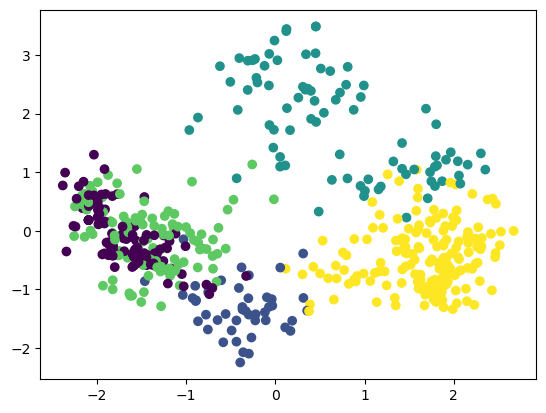

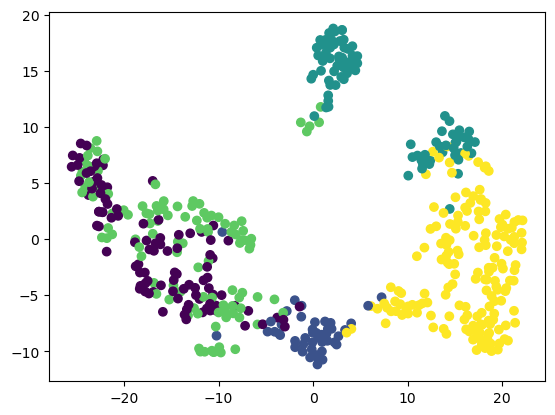

In [23]:
pca = PCA(n_components=2)
embeddings_english_2d = pca.fit_transform(embeddings_english)
plt.scatter(embeddings_english_2d[:,0], embeddings_english_2d[:,1], c=cluster_indices)
plt.show()

tsne = TSNE(n_components=2, verbose=0, perplexity=40)
embeddings_english_2d = tsne.fit_transform(embeddings_english_2d)
plt.scatter(embeddings_english_2d[:,0], embeddings_english_2d[:,1], c=cluster_indices)
plt.show()


### Try alternative indexing methods

In [24]:
num_tweets, embedding_dim = embeddings_arr.shape
results = {}
K = 5
num_clusters = K
indexing_methods = [
    faiss.IndexFlatL2(embedding_dim),
    faiss.IndexFlatIP(embedding_dim),
    faiss.IndexIVFFlat(faiss.IndexFlatL2(embedding_dim), embedding_dim, num_clusters, faiss.METRIC_L2),
    faiss.IndexHNSWFlat(embedding_dim, num_clusters),  # HNSW index
    faiss.IndexLSH(embedding_dim, num_clusters),  # LSH index
    faiss.IndexScalarQuantizer(embedding_dim, faiss.ScalarQuantizer.QT_8bit),  # Scalar quantizer
]



for index_method in indexing_methods:
    start_time = time.time()
    faiss.normalize_L2(embeddings_arr)

    # Initialize a K-Means index in Faiss
    index = faiss.IndexFlatL2(embedding_dim)  # L2 distance (Euclidean distance)

    # Train the K-Means model
    kmeans = faiss.Kmeans(embedding_dim, K)

    kmeans.index = index_method


    kmeans.train(embeddings_arr)  # You can optionally retrain the model

    # Perform clustering
    _, cluster_indices = kmeans.index.search(embeddings_arr, 1)  # Assign each point to the nearest cluster

    end_time = time.time()
    print("Clustering with indexing time for 500 Tweets: {}".format(end_time-start_time))

    results[str(index_method)] = {
        "clustering_time": end_time - start_time}
results


Clustering with indexing time for 500 Tweets: 0.05042672157287598
Clustering with indexing time for 500 Tweets: 0.03693389892578125
Clustering with indexing time for 500 Tweets: 0.031736135482788086
Clustering with indexing time for 500 Tweets: 0.03138613700866699
Clustering with indexing time for 500 Tweets: 0.02473592758178711
Clustering with indexing time for 500 Tweets: 0.033377885818481445


{"<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fd24e882c60> >": {'clustering_time': 0.05042672157287598},
 "<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fd24c7bfbd0> >": {'clustering_time': 0.03693389892578125},
 "<faiss.swigfaiss_avx2.IndexIVFFlat; proxy of <Swig Object of type 'faiss::IndexIVFFlat *' at 0x7fd24c7bfd80> >": {'clustering_time': 0.031736135482788086},
 "<faiss.swigfaiss_avx2.IndexHNSWFlat; proxy of <Swig Object of type 'faiss::IndexHNSWFlat *' at 0x7fd24c7bfe10> >": {'clustering_time': 0.03138613700866699},
 "<faiss.swigfaiss_avx2.IndexLSH; proxy of <Swig Object of type 'faiss::IndexLSH *' at 0x7fd23ec35030> >": {'clustering_time': 0.02473592758178711},
 "<faiss.swigfaiss_avx2.IndexScalarQuantizer; proxy of <Swig Object of type 'faiss::IndexScalarQuantizer *' at 0x7fd24c7a14e0> >": {'clustering_time': 0.033377885818481445}}

### Use 5000 tweets

#### With flat indexing

In [11]:
embeddings_arr_5000 = np.array(embeddings_5000)

In [25]:
start_time = time.time()
K = 5
num_tweets, embedding_dim = embeddings_arr_5000.shape
faiss.normalize_L2(embeddings_arr_5000)

# Initialize a K-Means index in Faiss
# index = faiss.IndexFlatL2(embedding_dim)  # L2 distance (Euclidean distance)

# Train the K-Means model
kmeans = faiss.Kmeans(embedding_dim, K)

kmeans.train(embeddings_arr_5000)
# Perform clustering
_, cluster_indices = kmeans.index.search(embeddings_arr_5000, 1)  # Assign each point to the nearest cluster
end_time = time.time()
print("Clustering without indexing time for 5000 Tweets: {}".format(end_time-start_time))


cluster_to_tweets = {cluster_id: [] for cluster_id in range(num_clusters)}

tweets_content = [ sample_tweets_5000[i] for i in range(num_tweets) ]


for tweet_idx, cluster_id in enumerate(cluster_indices):
    cluster_to_tweets[cluster_id[0]].append(tweets_content[tweet_idx])

cluster_data = []
for cluster_id, twe in cluster_to_tweets.items():
    for tweet in twe:
        cluster_data.append([cluster_id, tweet])


clusters= pd.DataFrame(cluster_data, columns=["Cluster", "Tweet"])

clusters

Clustering without indexing time for 5000 Tweets: 0.04227089881896973


,Cluster,Tweet
0,0,(من كان يريد حرث الآخرة نزد له في حرثه ومن كان يريد حرث الدنيا نؤته منها وما له في الآخرة من نصيب) [الشورى:20] <url>
1,0,سويت كل شي ياماتيتش 💔
2,0,جوفينكو وش قاعد يسوي!!
3,0,#اكتب_بيت_شعر_تحبه\n💜aA <url>
4,0,مسسسسسسااكم بنفسج 💜\nشكراا شكراا شكراا لكل من سأل عني باالخاص \nبعد صااروخ االحوثي كان قوي مره ويخوف حسبي الله ونعم االوكيل عليهم 😪\nاانا طيبه ااشكركم لاخلا ولاعدم ع سؤالكم 🙏 <url>
...,...,...
4995,4,ساعة صمارينر اوتوماتيك\n\nالتوصيل خلال ساعه الرياض\nخارج عن طريق الشحن مجانا <url>
4996,4,ساعة رولكس اوتوماتيك \n\nالتوصيل خلال ساعه الرياض\nخارج عن طريق الشحن مجانا <url>
4997,4,ساعة هوبلو جديد نسائيه\n\nالتوصيل خلال ساعه الرياض\nخارج عن طريق الشحن مجانا <url>
4998,4,#كم_ساعه_تقضيها_بالنت_يوميا\nلا وشحنه يقعد 66 ساعة😂 <url>


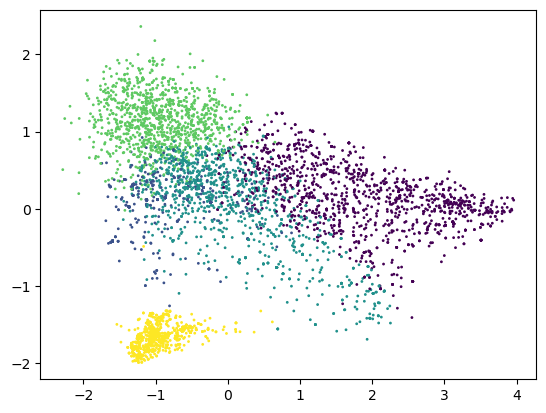

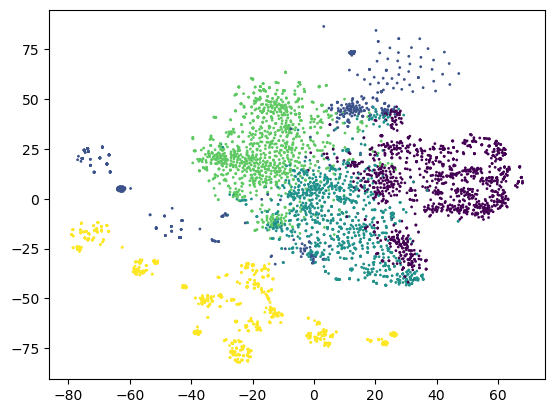

In [26]:
pca = PCA(n_components=2)
embeddings_5000_2d = pca.fit_transform(embeddings_5000)
plt.scatter(embeddings_5000_2d[:,0], embeddings_5000_2d[:,1], c=cluster_indices, s=1)
plt.show()


tsne = TSNE(n_components=2, verbose=0, perplexity=40)
embeddings_5000_2d = tsne.fit_transform(embeddings_5000)
plt.scatter(embeddings_5000_2d[:,0], embeddings_5000_2d[:,1], c=cluster_indices, s=1)
plt.show()

### Time spent on different indexing methods

HNSW index:   
an approximate nearest neighbor search method that organizes data points in a way that speeds up retrieval. It's efficient for very large datasets  
LSH index:   
It hashes data points in such a way that similar data points have a higher probability of landing in the same bucket.   
Scalar quantizer:   
a technique to reduce the dimensionality of data by quantizing values. This method is used for efficient storage and retrieval of high-dimensional data with a trade-off in retrieval accuracy.

In [34]:
num_tweets, embedding_dim = embeddings_arr_5000.shape
results = {}
K = 5
num_clusters = K
indexing_methods = [
    faiss.IndexFlatL2(embedding_dim),
    faiss.IndexFlatIP(embedding_dim),
    faiss.IndexIVFFlat(faiss.IndexFlatL2(embedding_dim), embedding_dim, num_clusters, faiss.METRIC_L2),
    faiss.IndexHNSWFlat(embedding_dim, num_clusters),  # HNSW index
    faiss.IndexLSH(embedding_dim, num_clusters),  # LSH index
    faiss.IndexScalarQuantizer(embedding_dim, faiss.ScalarQuantizer.QT_8bit),  # Scalar quantizer
]



for index_method in indexing_methods:
    start_time = time.time()
    faiss.normalize_L2(embeddings_arr_5000)

    # Initialize a K-Means index in Faiss
    index = faiss.IndexFlatL2(embedding_dim)  # L2 distance (Euclidean distance)

    # Train the K-Means model
    kmeans = faiss.Kmeans(embedding_dim, K)

    kmeans.index = index_method


    kmeans.train(embeddings_arr_5000)  # You can optionally retrain the model

    # Perform clustering
    _, cluster_indices = kmeans.index.search(embeddings_arr_5000, 1)  # Assign each point to the nearest cluster

    end_time = time.time()
    print("Clustering with indexing time for 5000 Tweets: {}".format(end_time-start_time))

    results[str(index_method)] = {
        "clustering_time": end_time - start_time}
results


Clustering with indexing time for 5000 Tweets: 0.15998506546020508
Clustering with indexing time for 5000 Tweets: 0.062332868576049805
Clustering with indexing time for 5000 Tweets: 0.04856681823730469
Clustering with indexing time for 5000 Tweets: 0.04710078239440918
Clustering with indexing time for 5000 Tweets: 0.047992706298828125
Clustering with indexing time for 5000 Tweets: 0.05798506736755371


{"<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fd24105d4b0> >": {'clustering_time': 0.15998506546020508},
 "<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fd24da06f00> >": {'clustering_time': 0.062332868576049805},
 "<faiss.swigfaiss_avx2.IndexIVFFlat; proxy of <Swig Object of type 'faiss::IndexIVFFlat *' at 0x7fd24da229f0> >": {'clustering_time': 0.04856681823730469},
 "<faiss.swigfaiss_avx2.IndexHNSWFlat; proxy of <Swig Object of type 'faiss::IndexHNSWFlat *' at 0x7fd24c7bfe40> >": {'clustering_time': 0.04710078239440918},
 "<faiss.swigfaiss_avx2.IndexLSH; proxy of <Swig Object of type 'faiss::IndexLSH *' at 0x7fd24da22f00> >": {'clustering_time': 0.047992706298828125},
 "<faiss.swigfaiss_avx2.IndexScalarQuantizer; proxy of <Swig Object of type 'faiss::IndexScalarQuantizer *' at 0x7fd24c7bfb10> >": {'clustering_time': 0.05798506736755371}}

### Find the optimal number of clusters using Elbow method

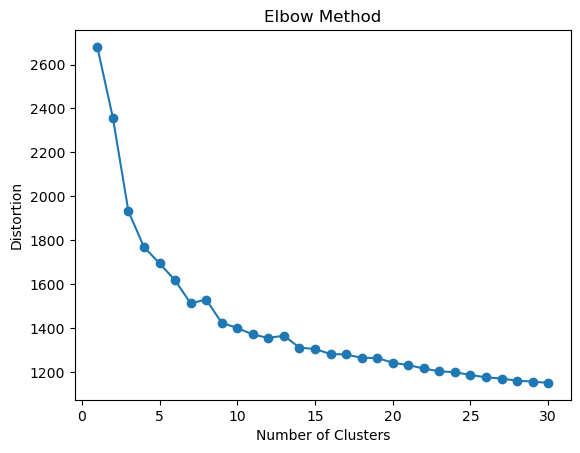

In [49]:
num_tweets, embedding_dim = embeddings_arr_5000.shape


# Normalize embeddings
faiss.normalize_L2(embeddings_arr_5000)

distortions = []

max_clusters = 30

for num_clusters in range(1, max_clusters + 1):

    kmeans = faiss.Kmeans(embedding_dim, num_clusters, niter=100, verbose=False)
    kmeans.train(embeddings_arr_5000)

    # Assign each tweet to a cluster
    _, cluster_indices = kmeans.index.search(embeddings_arr_5000, 1)

    wcss = 0
    for cluster_id in range(num_clusters):
        cluster_points = embeddings_arr_5000[cluster_indices[:, 0] == cluster_id]
        if len(cluster_points) > 0:
            cluster_center = np.mean(cluster_points, axis=0)
            wcss += np.sum((cluster_points - cluster_center) ** 2)


    # Compute the distortion (sum of squared distances) for this number of clusters
#     distortion = np.sum(np.min(np.square(embeddings_arr_5000 - kmeans.centroids[cluster_indices[:, 0]]), axis=1))
#     print(kmeans.centroids[cluster_indices[:, 0]].shape,embeddings_arr.shape)

    distortions.append(wcss)

# Plot the Elbow Method graph
plt.plot(range(1, max_clusters + 1), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()
# print(distortions)

## Other clustering method? agglomerative clustering

*The agglomerative clustering iteratively merging individual data points or small clusters into larger clusters. It starts with each data point as its own cluster and repeatedly merges the closest pairs of clusters until a desired number of clusters is reached.*

In [28]:
num_tweets, embedding_dim = embeddings_arr_5000.shape
faiss.normalize_L2(embeddings_arr)

num_clusters = 5

# Initialize agglomerative clustering index

clustering = faiss.Clustering(embedding_dim, num_clusters)

index = faiss.IndexFlatL2(embedding_dim)
clustering.clus_index = index

clustering.niter = 50

# Train the agglomerative clustering model
clustering.verbose = False  # Enable verbose output for training
clustering.train(embeddings_arr_5000, index)

_, labels = index.search(embeddings_arr_5000, 1)


cluster_to_tweets = {cluster_id: [] for cluster_id in range(num_clusters)}

tweets_content = [ sample_tweets_5000[i] for i in range(num_tweets) ]


for tweet_idx, cluster_id in enumerate(labels):
    cluster_to_tweets[cluster_id[0]].append(tweets_content[tweet_idx])

cluster_data = []
for cluster_id, twe in cluster_to_tweets.items():
    for tweet in twe:
        cluster_data.append([cluster_id, tweet])


clusters= pd.DataFrame(cluster_data, columns=["Cluster", "Tweet"])




#### Different indexing methods

In [37]:
num_tweets, embedding_dim = embeddings_arr_5000.shape
faiss.normalize_L2(embeddings_arr_5000)
results = {}
num_clusters = 5

indexing_methods = [
    faiss.IndexFlatL2(embedding_dim),
    faiss.IndexFlatIP(embedding_dim),
    faiss.IndexIVFFlat(faiss.IndexFlatL2(embedding_dim), embedding_dim, num_clusters, faiss.METRIC_L2),
    faiss.IndexHNSWFlat(embedding_dim, num_clusters),  # HNSW index
    faiss.IndexLSH(embedding_dim, num_clusters),  # LSH index
    faiss.IndexScalarQuantizer(embedding_dim, faiss.ScalarQuantizer.QT_8bit),  # Scalar quantizer
]
for index_method in indexing_methods:
    start_time = time.time()
    clustering = faiss.Clustering(embedding_dim, num_clusters)

    index = index_method
    clustering.clus_index = index

    clustering.niter = 50

    # Train the agglomerative clustering model
    clustering.verbose = False  # Enable verbose output for training
    clustering.train(embeddings_arr_5000, index)

    _, labels = index.search(embeddings_arr_5000, 1)
    end_time = time.time()
    print("Clustering with indexing time for 5000 Tweets: {}".format(end_time-start_time))

    results[str(index_method)] = {
        "clustering_time": end_time - start_time}
results

Clustering with indexing time for 5000 Tweets: 0.10212397575378418
Clustering with indexing time for 5000 Tweets: 0.10450100898742676


WARNING clustering 5 points to 5 centroids: please provide at least 195 training points


Clustering with indexing time for 5000 Tweets: 0.26079297065734863
Clustering with indexing time for 5000 Tweets: 0.03196907043457031
Clustering with indexing time for 5000 Tweets: 0.10964107513427734
Clustering with indexing time for 5000 Tweets: 0.045368194580078125


{"<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fd3ae09a3f0> >": {'clustering_time': 0.10212397575378418},
 "<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fd24e878d50> >": {'clustering_time': 0.10450100898742676},
 "<faiss.swigfaiss_avx2.IndexIVFFlat; proxy of <Swig Object of type 'faiss::IndexIVFFlat *' at 0x7fd24c7b1e40> >": {'clustering_time': 0.26079297065734863},
 "<faiss.swigfaiss_avx2.IndexHNSWFlat; proxy of <Swig Object of type 'faiss::IndexHNSWFlat *' at 0x7fd24e556630> >": {'clustering_time': 0.03196907043457031},
 "<faiss.swigfaiss_avx2.IndexLSH; proxy of <Swig Object of type 'faiss::IndexLSH *' at 0x7fd241042c00> >": {'clustering_time': 0.10964107513427734},
 "<faiss.swigfaiss_avx2.IndexScalarQuantizer; proxy of <Swig Object of type 'faiss::IndexScalarQuantizer *' at 0x7fd24e887480> >": {'clustering_time': 0.045368194580078125}}

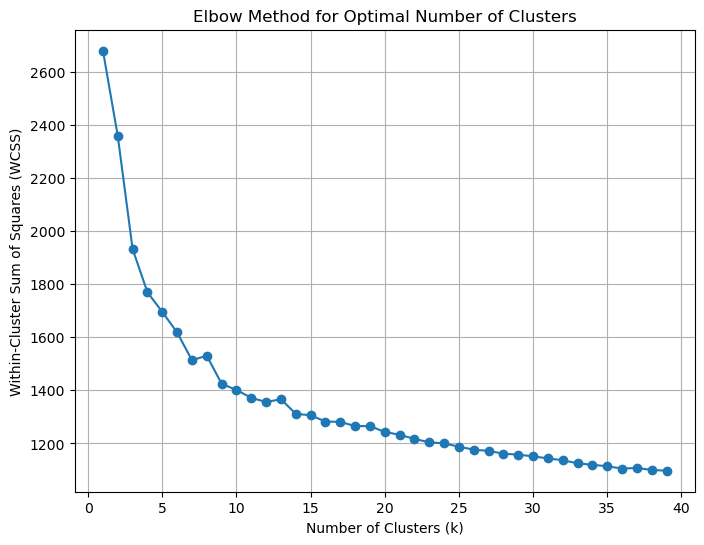

In [50]:
wcss_values = []
k_values = range(1, 40)  # Try different values of k
num_tweets, embedding_dim = embeddings_arr_5000.shape
faiss.normalize_L2(embeddings_arr_5000)



for k in k_values:
    num_clusters = k

    clustering = faiss.Clustering(embedding_dim, num_clusters)
    index = faiss.IndexFlatL2(embedding_dim)
    clustering.clus_index = index
    clustering.niter = 50
    clustering.verbose = False

    clustering.train(embeddings_arr_5000, index)

    _, labels = index.search(embeddings_arr_5000, 1)
    wcss = 0
    for cluster_id in range(k):
        cluster_points = embeddings_arr_5000[labels[:, 0] == cluster_id]
        if len(cluster_points) > 0:
            cluster_center = np.mean(cluster_points, axis=0)
            wcss += np.sum((cluster_points - cluster_center) ** 2)

    wcss_values.append(wcss)

plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss_values, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()
